### Cleaning and Database Creation

Cleaning goals
- remove duplicates
- remove scraped at column
- measure field completion
- ensure that branching numbers are always lower than bud counts (flipping values if necessary)
- remove specific varieties that are outliers for numeric columns 

Database creation
- create a query-able sqlite3 database and populate it with the cleaned data


In [10]:
!pip install IPython scipy matplotlib numpy pandas seaborn

In [11]:
import pandas as pd
import sqlite3
import numpy as np
import json
import scipy

df = pd.read_json('daylilies.jsonl', lines=True)

# Display head  
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102611 entries, 0 to 102610
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   url                102611 non-null  object        
 1   scraped_at         102611 non-null  datetime64[ns]
 2   name               102611 non-null  object        
 3   hybridizer         102611 non-null  object        
 4   year               102611 non-null  int64         
 5   scape_height       102258 non-null  object        
 6   bloom_size         94653 non-null   object        
 7   bloom_season       101871 non-null  object        
 8   ploidy             100838 non-null  object        
 9   foliage_type       100287 non-null  object        
 10  fragrance          33523 non-null   object        
 11  bloom_habit        96679 non-null   object        
 12  bud_count          53990 non-null   float64       
 13  branches           54127 non-n

In [12]:
# Remove scraped column
df = df.drop('scraped_at', axis=1)
#  Print columns
print(df.columns.tolist())

['url', 'name', 'hybridizer', 'year', 'scape_height', 'bloom_size', 'bloom_season', 'ploidy', 'foliage_type', 'fragrance', 'bloom_habit', 'bud_count', 'branches', 'seedling_#', 'color_description', 'parentage', 'image_url', 'form', 'sculpting', 'notes']


In [13]:
# drop empty hybridizer rows
initial_count = len(df)
df = df[df['hybridizer'].notna()]
removed_count = initial_count - len(df)
print(f"\nRemoved {removed_count} rows with missing hybridizer names")


Removed 0 rows with missing hybridizer names


In [14]:
# Drop Duplicates
# Count initial number of rows
initial_count = len(df)

# Count non-null values for each row
completeness = df.notna().sum(axis=1)

# Sort by completeness (most complete first) and drop duplicates based on name
df = df.assign(completeness=completeness)\
       .sort_values('completeness', ascending=False)\
       .drop_duplicates(subset='name', keep='first')\
       .drop('completeness', axis=1)

# Count final number of rows and display summary
final_count = len(df)
duplicates_removed = initial_count - final_count

print(f"Initial number of rows: {initial_count}")
print(f"Final number of rows: {final_count}")
print(f"Number of duplicates removed: {duplicates_removed}")


Initial number of rows: 102611
Final number of rows: 101718
Number of duplicates removed: 893


In [15]:
#Field completion statistics
total_rows = len(df)

# Calculate completion stats for each column
completion_stats = pd.DataFrame({
    'Total_Values': df.count(),
    'Missing_Values': df.isna().sum(),
    'Completion_Rate': (df.count() / total_rows * 100).round(2),
    'Data_Type': df.dtypes
})

# Sort by completion rate
completion_stats = completion_stats.sort_values('Completion_Rate', ascending=False)

# Add %
completion_stats['Completion_Rate'] = completion_stats['Completion_Rate'].apply(lambda x: f"{x}%")

print(f"Field Completion Statistics (Total Rows: {total_rows}):\n")
print(completion_stats)


Field Completion Statistics (Total Rows: 101718):

                   Total_Values  Missing_Values Completion_Rate Data_Type
url                      101718               0          100.0%    object
name                     101718               0          100.0%    object
hybridizer               101718               0          100.0%    object
year                     101718               0          100.0%     int64
color_description        101667              51          99.95%    object
scape_height             101366             352          99.65%    object
bloom_season             100980             738          99.27%    object
ploidy                    99952            1766          98.26%    object
foliage_type              99407            2311          97.73%    object
parentage                 97793            3925          96.14%    object
bloom_habit               95828            5890          94.21%    object
bloom_size                93814            7904          92.2

In [16]:
# Separate rebloom from bloom season

# Create rebloom column - check when rebloom appears in bloom_season
df['rebloom'] = df['bloom_season'].str.contains('Rebloom', case=False, na=False)

# Clean bloom season column
df['bloom_season'] = df['bloom_season'].str.replace(',Rebloom', '', case=False, regex=False)
df['bloom_season'] = df['bloom_season'].str.strip()  # Remove spaces

# Display the results
print(f"\nRebloom distribution:")
print(df['rebloom'].value_counts())

print(f"\nSample of bloom_season values after cleaning:")
print(df['bloom_season'].value_counts().head(15))



Rebloom distribution:
rebloom
False    55612
True     46106
Name: count, dtype: int64

Sample of bloom_season values after cleaning:
bloom_season
Midseason          43605
Early-Midseason    29224
Midseason-Late     13772
Early               9293
Late                2730
Extra Early         1728
Very Late            581
                      47
Name: count, dtype: int64


In [17]:
# count rows where branching > bud_count
# look at rows where both values are present
rows_with_both = df[df['branches'].notna() & df['bud_count'].notna()]
incorrect_order = rows_with_both[rows_with_both['branches'] > rows_with_both['bud_count']]

print(f"Total rows with both branches and bud_count: {len(rows_with_both)}")
print(f"Rows where branches > bud_count: {len(incorrect_order)}")

if len(incorrect_order) > 0:
    print("\nExample of rows that need fixing:")
    print(incorrect_order[['name', 'branches', 'bud_count']].head())

    # Create a mask for rows that need switching
    swap_mask = (df['branches'] > df['bud_count']) & df['branches'].notna() & df['bud_count'].notna()
    
    # Swap the values where needed
    df.loc[swap_mask, ['branches', 'bud_count']] = df.loc[swap_mask, ['bud_count', 'branches']].values

    # Verify
    rows_with_both_after = df[df['branches'].notna() & df['bud_count'].notna()]
    still_incorrect = rows_with_both_after[rows_with_both_after['branches'] > rows_with_both_after['bud_count']]
    
    print("\nAfter fixing:")
    print(f"Rows where branches > bud_count: {len(still_incorrect)}")
    
    if len(incorrect_order) > 0:
        print("\nExample of fixed rows:")
        print(df.loc[incorrect_order.index, ['name', 'branches', 'bud_count']].head())

Total rows with both branches and bud_count: 53219
Rows where branches > bud_count: 160

Example of rows that need fixing:
                                   name  branches  bud_count
33425  Gary is Blues and Celtic Thunder       3.0        2.0
90084                     Super Gabriel       6.0        5.0
92584                     The Big House      18.0        2.0
91741                Taunus Bitone Spin       5.0        3.0
91764                Taunus Fire Dragon       5.0        3.0

After fixing:
Rows where branches > bud_count: 0

Example of fixed rows:
                                   name  branches  bud_count
33425  Gary is Blues and Celtic Thunder       2.0        3.0
90084                     Super Gabriel       5.0        6.0
92584                     The Big House       2.0       18.0
91741                Taunus Bitone Spin       3.0        5.0
91764                Taunus Fire Dragon       3.0        5.0


In [18]:
# remove varieties introduced before 1760 /+ 2024
initial_count = len(df)

df = df[df['year'].isna() | ((df['year'] >= 1760) & (df['year'] <= 2024))]

removed_count = initial_count - len(df)
print(f"\nRemoved {removed_count} varieties introduced before 1760 or after 2024")


Removed 312 varieties introduced before 1760 or after 2024


In [19]:
# Specific varieties where fields combined represent most fields
varieties_to_check = ['Apophis', 'Citrina']
debug_df = df[df['name'].isin(varieties_to_check)]

# Display all columns for these varieties
print("Full details for specified varieties:")
for idx, row in debug_df.iterrows():
    print(f"\nVariety: {row['name']}")
    for column in df.columns:
        print(f"{column}: {row[column]} (type: {type(row[column])})")


Full details for specified varieties:

Variety: Apophis
url: https://daylilydatabase.org/detail.php?id=156583&name=Apophis (type: <class 'str'>)
name: Apophis (type: <class 'str'>)
hybridizer: Mahieu-Burris (type: <class 'str'>)
year: 2007 (type: <class 'int'>)
scape_height: 42 in, (107 cm) (type: <class 'str'>)
bloom_size: 7.5 in, (19 cm) (type: <class 'str'>)
bloom_season: Midseason (type: <class 'str'>)
ploidy: Diploid (type: <class 'str'>)
foliage_type: Dormant (type: <class 'str'>)
fragrance: nan (type: <class 'float'>)
bloom_habit: nan (type: <class 'float'>)
bud_count: 26.0 (type: <class 'float'>)
branches: 4.0 (type: <class 'float'>)
seedling_#: MB-1 (type: <class 'str'>)
color_description: black purple self above chartreuse throat (type: <class 'str'>)
parentage: ((sdlg × (Serpent's Tooth × Satyr)) × (Satchmo × Blue Venture)) (type: <class 'str'>)
image_url: https://daylilydatabase.org/AHSPhoto/A/Apophis.jpg (type: <class 'str'>)
form: Unusual FormCrispate (type: <class 'str'>

In [20]:
# Function to extract the inch measurement
def extract_inches(x):
    if pd.isna(x):
        return np.nan
    try:
        # Split on 'in,' and take the first part, then convert to float
        inches = float(x.split('in,')[0].strip())
        return inches
    except:
        return np.nan

# Apply the conversion to both columns
df['scape_height'] = df['scape_height'].apply(extract_inches)
df['bloom_size'] = df['bloom_size'].apply(extract_inches)

In [21]:
# Check various IQR multipliers to identify outlier value bounds

# Get numeric columns (excluding year)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'year']

# Identify outliers with adjustable IQR multiplier
def identify_outliers(df, column, iqr_multiplier=2.0): 
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print(f"\nOutlier Analysis for {column} (IQR multiplier: {iqr_multiplier}):")
    print(f"Q1: {Q1:.2f}")
    print(f"Median: {df[column].median():.2f}")
    print(f"Q3: {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Lower bound: {lower_bound:.2f}")
    print(f"Upper bound: {upper_bound:.2f}")
    print(f"Number of potential outliers: {len(outliers)} ({(len(outliers)/len(df)*100):.1f}% of data)")
    
    if len(outliers) > 0:
        print("\nSample of outliers:")
        print(outliers[['name', column]].head().to_string())
        
    return outliers, lower_bound, upper_bound

# IQR multipliers
multipliers = [1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

print("Comparison of different IQR multipliers:")
for col in numeric_cols:
    print(f"\n{'='*50}")
    print(f"Column: {col}")
    print(f"Total values: {df[col].count()}")
    print(f"Current range: {df[col].min():.2f} to {df[col].max():.2f}")
    
    for mult in multipliers:
        outliers, lower, upper = identify_outliers(df, col, mult)
        print(f"\nWith {mult}x IQR multiplier:")
        print(f"Would retain: {len(df[(df[col] >= lower) & (df[col] <= upper)])} entries")
        print(f"Would replace: {len(outliers)} entries")


Comparison of different IQR multipliers:

Column: scape_height
Total values: 101061
Current range: 2.00 to 96.00

Outlier Analysis for scape_height (IQR multiplier: 1.5):
Q1: 25.00
Median: 28.00
Q3: 33.00
IQR: 8.00
Lower bound: 13.00
Upper bound: 45.00
Number of potential outliers: 2526 (2.5% of data)

Sample of outliers:
                                name  scape_height
84396  Small World Cool Morning Mist          48.0
5439                            Baku          48.0
15329                       Chang-an          48.0
84375      Small World Christmas Eve          50.0
84443      Small World Evelyn Miller          52.0

With 1.5x IQR multiplier:
Would retain: 98535 entries
Would replace: 2526 entries

Outlier Analysis for scape_height (IQR multiplier: 2.0):
Q1: 25.00
Median: 28.00
Q3: 33.00
IQR: 8.00
Lower bound: 9.00
Upper bound: 49.00
Number of potential outliers: 996 (1.0% of data)

Sample of outliers:
                               name  scape_height
84375     Small World Christ

In [22]:
import pandas as pd
import numpy as np

def replace_outliers_with_nan(df, column, iqr_multiplier=5.0):
    # Calculate IQR bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    
    # Create a copy of the column
    cleaned_column = df[column].copy()
    
    # Count original non-NaN values
    original_count = cleaned_column.notna().sum()
    
    # Identify outliers
    outlier_mask = (
        cleaned_column.notna() & 
        ((cleaned_column < lower_bound) | (cleaned_column > upper_bound))
    )
    
    # Count outliers found
    outliers_found = outlier_mask.sum()
    
    # Replace outliers with NaN
    cleaned_column[outlier_mask] = np.nan
    
    # Count final non-NaN values
    final_count = cleaned_column.notna().sum()
    
    # Print summary
    print(f"\n{column}:")
    print(f"  Original non-NaN values: {original_count:,}")
    print(f"  Outliers found: {outliers_found:,}")
    print(f"  Values after cleaning: {final_count:,}")
    print(f"  Range: {lower_bound:.1f} to {upper_bound:.1f}")
    
    if outliers_found > 0:
        outlier_values = df.loc[outlier_mask, column].values
        print(f"  Sample outlier values: {sorted(outlier_values)[:5]}")
    
    return cleaned_column

def clean_all_outliers(df, numeric_columns=None, iqr_multipliers=None):
    # Create a copy of the dataframe
    df_cleaned = df.copy()
    
    # Auto-detect numeric columns
    if numeric_columns is None:
        numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        numeric_columns = [col for col in numeric_columns if col != 'year']
    
    print()
    print("CLEANING OUTLIERS")
    print()
    
    # Process each column
    for column in numeric_columns:
        multiplier = iqr_multipliers.get(column, 5.0)
        df_cleaned[column] = replace_outliers_with_nan(df_cleaned, column, multiplier)
    
    return df_cleaned

# Define the numeric columns for cleaning
numeric_cols = ['scape_height', 'bloom_size', 'bud_count', 'branches']

# Define IQR multipliers
iqr_multipliers = {
    'scape_height': 5.0, 
    'bloom_size': 5.0,      
    'bud_count': 5.0,       
    'branches': 5.5         
}

# Cleaning function call
df_cleaned = clean_all_outliers(df, numeric_cols, iqr_multipliers)

# Results
print("\nBEFORE vs AFTER CLEANING:")
print()
for col in numeric_cols:
    before_count = df[col].notna().sum()
    after_count = df_cleaned[col].notna().sum()
    removed = before_count - after_count
    print(f"{col:15}: {before_count:6,} -> {after_count:6,} (removed {removed:3,})")



CLEANING OUTLIERS


scape_height:
  Original non-NaN values: 101,061
  Outliers found: 16
  Values after cleaning: 101,045
  Range: -15.0 to 73.0
  Sample outlier values: [74.0, 74.0, 74.0, 74.0, 75.0]

bloom_size:
  Original non-NaN values: 93,509
  Outliers found: 19
  Values after cleaning: 93,490
  Range: -2.5 to 14.0
  Sample outlier values: [14.5, 15.0, 15.0, 15.2, 15.5]

bud_count:
  Original non-NaN values: 53,138
  Outliers found: 19
  Values after cleaning: 53,119
  Range: -30.0 to 69.0
  Sample outlier values: [70.0, 70.0, 70.0, 70.0, 70.0]

branches:
  Original non-NaN values: 53,274
  Outliers found: 54
  Values after cleaning: 53,220
  Range: -2.5 to 9.5
  Sample outlier values: [10.0, 10.0, 10.0, 10.0, 10.0]

BEFORE vs AFTER CLEANING:

scape_height   : 101,061 -> 101,045 (removed  16)
bloom_size     : 93,509 -> 93,490 (removed  19)
bud_count      : 53,138 -> 53,119 (removed  19)
branches       : 53,274 -> 53,220 (removed  54)


Save cleaned data to an sql db (sqlite3)

In [23]:
import sqlite3

# Fix column names
df_for_sql = df_cleaned.copy()

# Replace problematic characters with underscores and make lowercase
clean_columns = [col.replace('#', 'num').replace(' ', '_').lower() for col in df_for_sql.columns]
df_for_sql.columns = clean_columns

# Create database connection
db_path = 'daylilies.db'
conn = sqlite3.connect(db_path)

try:
    # Save directly to SQLite
    df_for_sql.to_sql(
        name='daylilies',
        con=conn,
        if_exists='replace',
        index=False,             
    )
    print("Data saved to daylilies.db")
    
except Exception as e:
    print(f"Error: Failed to save data - {str(e)}")

finally:
    # close the connection
    conn.close()
    print("Database connection closed")

Data saved to daylilies.db
Database connection closed


In [24]:
# Saving data to multiple formats
import json
import csv
from pathlib import Path

# Create an output directory if it doesn't exist
output_dir = Path('cleaned_data')
output_dir.mkdir(exist_ok=True)

# Function to verify file was created and is readable
def verify_file(filepath):
    if filepath.exists():
        size = filepath.stat().st_size
        print(f"Created {filepath.name} (Size: {size:,} bytes)")
        return True
    else:
        print(f"Failed to create {filepath.name}")
        return False

try:
    # Save as CSV
    csv_path = output_dir / 'daylilies_cleaned.csv'
    df_cleaned.to_csv(csv_path, index=False)
    verify_file(csv_path)
    
    # Save as TXT (tab-separated)
    txt_path = output_dir / 'daylilies_cleaned.txt'
    df_cleaned.to_csv(txt_path, sep='\t', index=False)
    verify_file(txt_path)
    
    # Save as JSON
    
    # Regular JSON
    json_records_path = output_dir / 'daylilies_cleaned.json'
    df_cleaned.to_json(json_records_path, orient='records', indent=2)
    verify_file(json_records_path)
    
    # JSON Lines
    jsonl_path = output_dir / 'daylilies_cleaned.jsonl'
    df_cleaned.to_json(jsonl_path, orient='records', lines=True)
    verify_file(jsonl_path)

    # Print summary
    print("\nSummary of saved files:")
    print(f"CSV: {csv_path}")
    print(f"TXT: {txt_path}")
    print(f"JSON: {json_records_path}")
    print(f"JSONL: {jsonl_path}")
    
except Exception as e:
    print(f"Error occurred while saving files: {str(e)}")

Created daylilies_cleaned.csv (Size: 31,305,872 bytes)
Created daylilies_cleaned.txt (Size: 31,260,150 bytes)
Created daylilies_cleaned.json (Size: 72,694,438 bytes)
Created daylilies_cleaned.jsonl (Size: 61,438,370 bytes)

Summary of saved files:
CSV: cleaned_data/daylilies_cleaned.csv
TXT: cleaned_data/daylilies_cleaned.txt
JSON: cleaned_data/daylilies_cleaned.json
JSONL: cleaned_data/daylilies_cleaned.jsonl


### PT. 2 Data Exploration Visualization

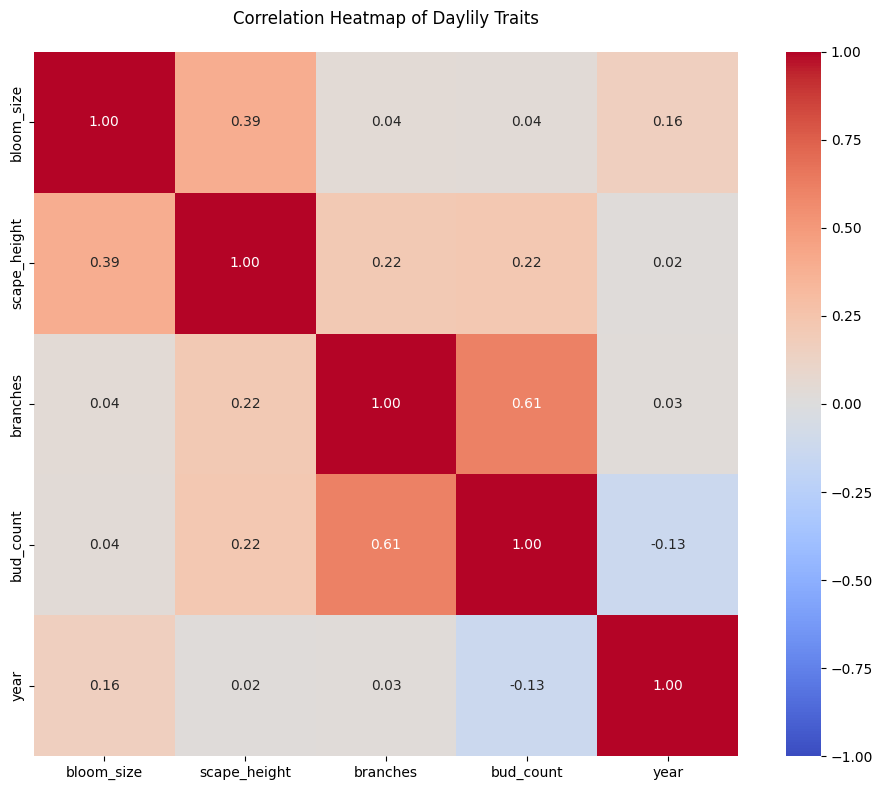


Correlation Matrix:
              bloom_size  scape_height  branches  bud_count   year
bloom_size         1.000         0.394     0.040      0.036  0.158
scape_height       0.394         1.000     0.216      0.224  0.020
branches           0.040         0.216     1.000      0.611  0.027
bud_count          0.036         0.224     0.611      1.000 -0.126
year               0.158         0.020     0.027     -0.126  1.000


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# numerical columns
numerical_traits = ['bloom_size', 'scape_height', 'branches', 'bud_count', 'year']

# correlation matrix
correlation_matrix = df_cleaned[numerical_traits].corr()

# Set figure
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Set correlation range
            center=0,  # Center at 0
            square=True,  # Make square
            fmt='.2f') # Set to 2 decimals

# Set title
plt.title('Correlation Heatmap of Daylily Traits', pad=20)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print the actual correlation values for reference
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

<Figure size 1200x1200 with 0 Axes>

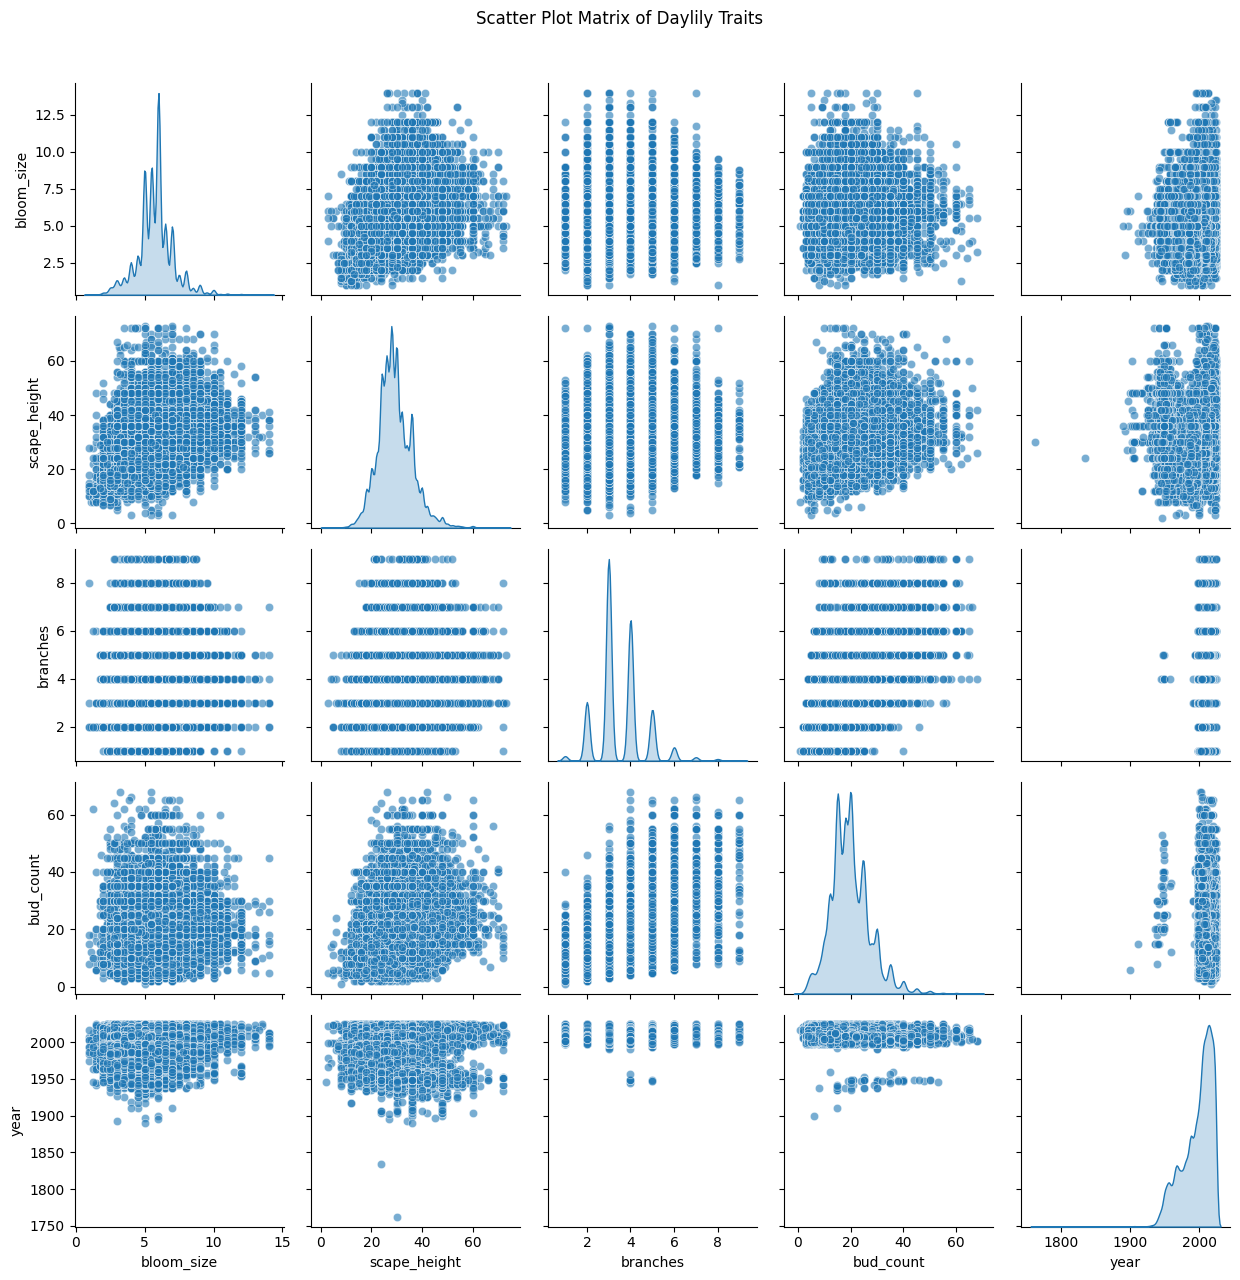

In [26]:
# Scatter Plot Matrix
plt.figure(figsize=(12, 12))
sns.pairplot(
    data=df_cleaned[numerical_traits],
    diag_kind='kde',          # Show density plots on diagonal
    plot_kws={'alpha': 0.6},  # Set transparency for better visibility
    diag_kws={'fill': True}   # Fill diagonal plots
)

plt.suptitle('Scatter Plot Matrix of Daylily Traits', y=1.02)
plt.tight_layout()
plt.show()

In [27]:
# Celculate Basic Stats
# Define traits
continuous_traits = ['bloom_size', 'scape_height', 'branches', 'bud_count']

# Calculate statistics
def get_trait_stats(data, trait):
    stats_dict = {
        'count': data[trait].count(),
        'mean': data[trait].mean(),
        'median': data[trait].median(), 
        'mode': data[trait].mode().iloc[0],
        'std': data[trait].std(),
        'min': data[trait].min(),
        'max': data[trait].max(),
        'skewness': data[trait].skew(),
        'kurtosis': data[trait].kurtosis()
    }
    return stats_dict

# Print stats for each
for trait in continuous_traits:
    stats = get_trait_stats(df_cleaned, trait)
    print(f"\n{trait} STATISTICS:")
    print("-" * 30)
    for stat_name, value in stats.items():
        print(f"{stat_name}: {value:.2f}")


bloom_size STATISTICS:
------------------------------
count: 93490.00
mean: 5.75
median: 6.00
mode: 6.00
std: 1.29
min: 1.00
max: 14.00
skewness: 0.39
kurtosis: 2.20

scape_height STATISTICS:
------------------------------
count: 101045.00
mean: 29.26
median: 28.00
mode: 28.00
std: 6.82
min: 2.00
max: 73.00
skewness: 0.72
kurtosis: 1.93

branches STATISTICS:
------------------------------
count: 53220.00
mean: 3.51
median: 3.00
mode: 3.00
std: 1.06
min: 1.00
max: 9.00
skewness: 0.83
kurtosis: 1.80

bud_count STATISTICS:
------------------------------
count: 53119.00
mean: 19.80
median: 19.00
mode: 20.00
std: 7.40
min: 1.00
max: 68.00
skewness: 0.88
kurtosis: 2.04


In [28]:

# Setup plot parameters
num_traits = len(traits)        # get count of num of traits
num_columns = 2                 # 2 plots side by side
plot_width = 15                 # Total width of fig
plot_height = 5 * num_traits    # Height per trait row

# Create the subplot grid
#   - a fig that holds all plots
#   - a grid of subplot axes
fig, axes = plt.subplots(
    nrows=num_traits,    # One row per trait
    ncols=num_columns,   # Two columns for dif plot types
    figsize=(plot_width, plot_height)
)

# Plot each trait's data
# Loop through each trait
for row_index, trait_name in enumerate(traits):
    histogram_axis = axes[row_index, 0] 
    sns.histplot(
        data=df_cleaned,
        x=trait_name,
        kde=True,
        ax=histogram_axis
    )
    histogram_axis.set_title(f'Distribution of {trait_name}')
    
    # Histogram mean and median lines
    mean_value = df_cleaned[trait_name].mean()
    median_value = df_cleaned[trait_name].median()
    
    # Mean Med vertical lines
    histogram_axis.axvline(
        x=mean_value,
        color='red',
        linestyle='--',
        label='Mean'
    )
    histogram_axis.axvline(
        x=median_value,
        color='green',
        linestyle='--',
        label='Median'
    )
    histogram_axis.legend()
    
    # Box plot (right column)
    boxplot_axis = axes[row_index, 1]
    sns.boxplot(
        data=df_cleaned,
        y=trait_name,
        ax=boxplot_axis
    )
    boxplot_axis.set_title(f'Box Plot of {trait_name}')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


NameError: name 'traits' is not defined

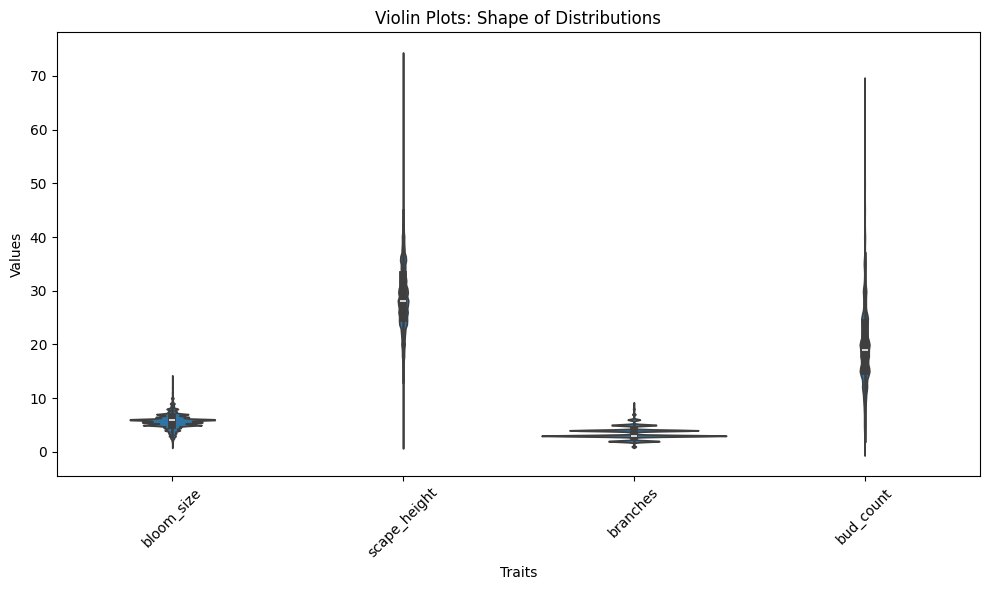

In [ ]:
# Violin plots for continuous traits
plt.figure(figsize=(10, 6))
df_continuous = df_cleaned[continuous_traits].melt()
sns.violinplot(data=df_continuous, x='variable', y='value')
plt.title('Violin Plots: Shape of Distributions')
plt.xticks(rotation=45)
plt.xlabel('Traits')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

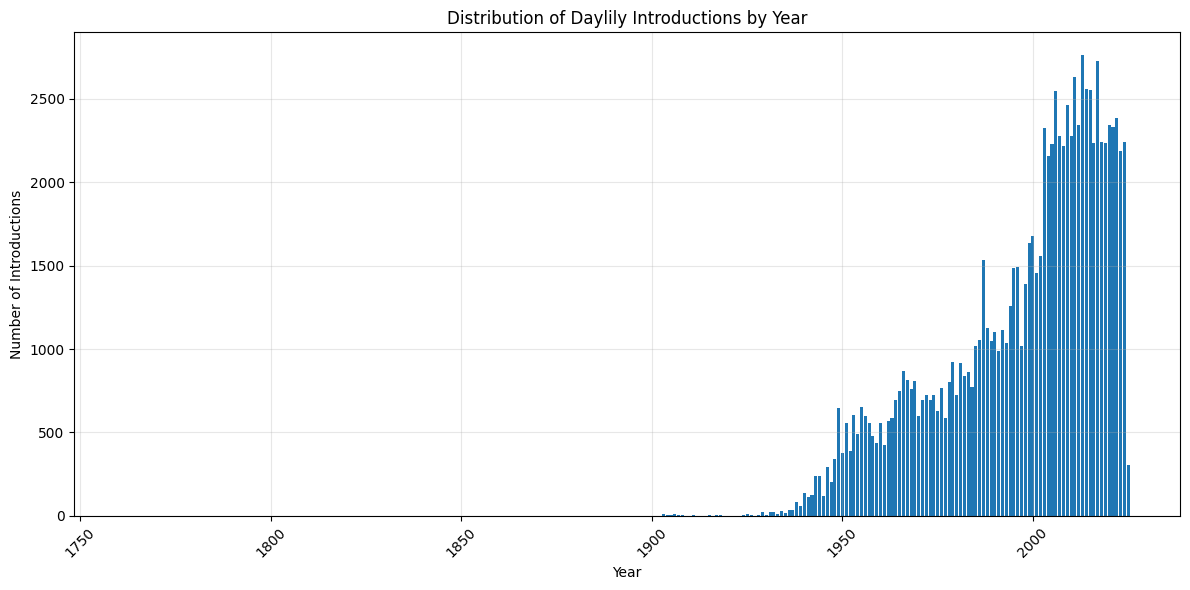

In [ ]:
# Year Distribution Bar Plot
plt.figure(figsize=(12, 6))
year_counts = df_cleaned['year'].value_counts().sort_index()

# Bar plot
plt.bar(year_counts.index, year_counts.values)
plt.title('Distribution of Daylily Introductions by Year')
plt.xlabel('Year')
plt.ylabel('Number of Introductions')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

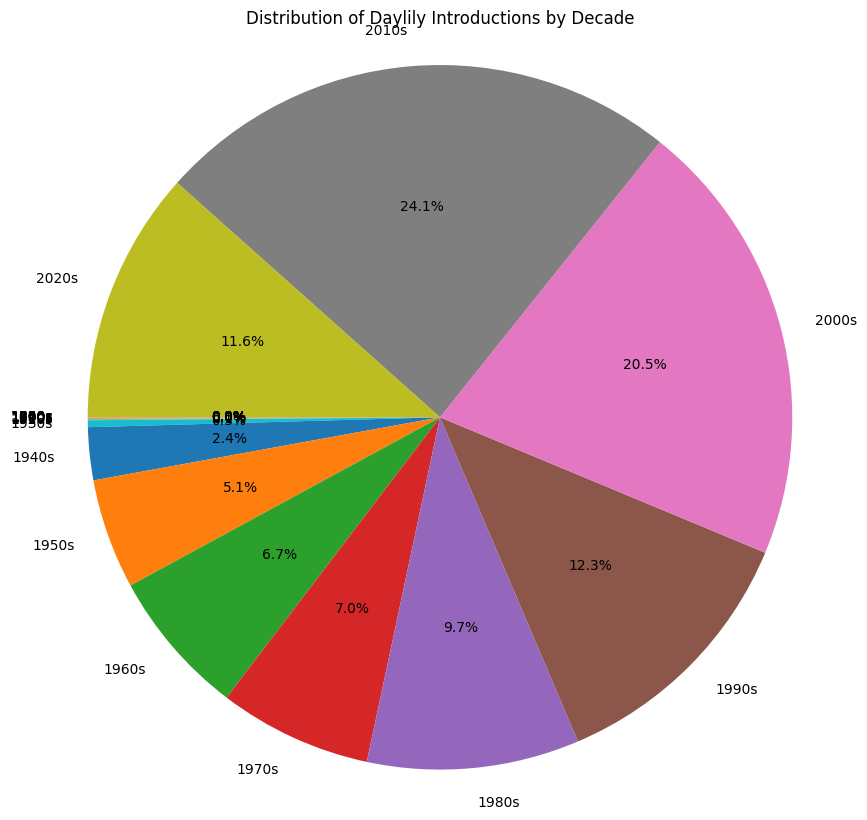


Decade Distribution Summary:
1760s: 2 introductions (0.0%)
1800s: 1 introductions (0.0%)
1820s: 1 introductions (0.0%)
1830s: 1 introductions (0.0%)
1860s: 1 introductions (0.0%)
1890s: 7 introductions (0.0%)
1900s: 44 introductions (0.0%)
1910s: 21 introductions (0.0%)
1920s: 56 introductions (0.1%)
1930s: 322 introductions (0.3%)
1940s: 2,462 introductions (2.4%)
1950s: 5,140 introductions (5.1%)
1960s: 6,836 introductions (6.7%)
1970s: 7,144 introductions (7.0%)
1980s: 9,907 introductions (9.7%)
1990s: 12,522 introductions (12.3%)
2000s: 20,900 introductions (20.5%)
2010s: 24,554 introductions (24.1%)
2020s: 11,790 introductions (11.6%)


In [ ]:
# Year Distribution Pie Chart
plt.figure(figsize=(10, 10))

# Group years into decades
df['decade'] = (df_cleaned['year'] // 10) * 10
decade_counts = df['decade'].value_counts().sort_index()

# Create pie chart
plt.pie(
    decade_counts.values,
    labels=[f"{int(year)}s" for year in decade_counts.index],
    autopct='%1.1f%%',
    startangle=180
)
plt.title('Distribution of Daylily Introductions by Decade')
plt.axis('equal')
plt.show()

print("\nDecade Distribution Summary:")
for decade, count in decade_counts.items():
    print(f"{int(decade)}s: {count:,} introductions ({count/len(df)*100:.1f}%)")

In [29]:
from scipy import stats

print("NORMALITY TESTS (Shapiro-Wilk)")
print("=" * 40)
print("H0: Data follows normal distribution")
print("H1: Data does not follow normal distribution")
print("Reject H0 if p-value < 0.05\n")

for trait in continuous_traits:
    statistic, p_value = stats.shapiro(df_cleaned[trait].dropna())
    is_normal = "YES" if p_value >= 0.05 else "NO"
    
    print(f"{trait}:")
    print(f"  Statistic: {statistic:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Normal? {is_normal}")
    print()

NORMALITY TESTS (Shapiro-Wilk)
H0: Data follows normal distribution
H1: Data does not follow normal distribution
Reject H0 if p-value < 0.05

bloom_size:
  Statistic: 0.9561
  p-value: 0.0000
  Normal? NO

scape_height:
  Statistic: 0.9686
  p-value: 0.0000
  Normal? NO

branches:
  Statistic: 0.8874
  p-value: 0.0000
  Normal? NO

bud_count:
  Statistic: 0.9582
  p-value: 0.0000
  Normal? NO



/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 93490.
  res = hypotest_fun_out(*samples, **kwds)
/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 101045.
  res = hypotest_fun_out(*samples, **kwds)
/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 53220.
  res = hypotest_fun_out(*samples, **kwds)
/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 53119.
  res = hypotest_fun_out(*samples, **kwds)


## Analysis Conclusions

### Key Finding (after cleaning):
1. Dataset Scale: 
        total_varieties: 101718
        unique daylily varieties spanning from 1763 to 2025
        columns: 21 
              ['url', 'name', 'hybridizer', 'year', 'scape_height', 'bloom_size', 'rebloom', 'bloom_season', 'ploidy', 'foliage_type', 'fragrance', 'bloom_habit', 'bud_count', 'branches', 'seedling_#', 'color_description', 'parentage', 'image_url', 'form', 'sculpting', 'notes']

2. Trait Distributions:
         bloom_size STATISTICS:
         ------------------------------
         count: 93795.00
         mean: 5.75
         median: 6.00
         mode: 6.00
         std: 1.29
         min: 1.00
         max: 14.00
         skewness: 0.39
         kurtosis: 2.20

         scape_height STATISTICS:
         ------------------------------
         count: 101350.00
         mean: 29.26
         median: 28.00
         mode: 28.00
         std: 6.82
         min: 2.00
         max: 73.00
         skewness: 0.72
         kurtosis: 1.93

         branches STATISTICS:
         ------------------------------
         count: 53518.00
         mean: 3.51
         median: 3.00
         mode: 3.00
         std: 1.06
         min: 1.00
         max: 9.00
         skewness: 0.83
         kurtosis: 1.80

         bud_count STATISTICS:
         ------------------------------
         count: 53418.00
         mean: 19.79
         median: 19.00
         mode: 20.00
         std: 7.40
         min: 1.00
         max: 68.00
         skewness: 0.88
         kurtosis: 2.04

3. Notable Correlations:
   - Strongest positive correlation: branching and bud count (o.61)
   - Strongest negative correlation: no super strong negative correlations, mostly neutral correlations

4. Data Quality:
   - Overall completeness: %
   - Most complete trait: name, year, hybridizer (100%)
   - Least complete trait: scuplpting (1.07%)
